In [15]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class movePos(gym.Env):
    def __init__(self,config=None):
        self.current_steps = 0
        self.grid_size = 2
        self.action_space = spaces.Discrete(4) # left,right
        self.observation_space = spaces.Dict({
            'position': spaces.Box(low=0, high=self.grid_size, shape=(2,)),
            'grid': spaces.Box(low=0, high=self.grid_size**2-1, shape=(self.grid_size, self.grid_size), dtype=np.int32)
        })
        # self.observation_space = spaces.Box(low=0, high=self.grid_size**2-1, shape=(self.grid_size, self.grid_size), dtype=np.int32)
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]
    
    def reset(self, *, seed=None, options=None):
        self._max_episode_steps = 100
        self.current_steps = 0
        self.state = np.arange(0,self.grid_size**2)
        self.np_random.shuffle(self.state)
        self.state = self.state.reshape(self.grid_size,self.grid_size)
        self.one_pos = np.argwhere(self.state==1)[0]
        obs = {
            "position": self.one_pos,
            "grid": self.state,
        }
        return obs,{"one_pos":self.one_pos}
    
    def step(self,action):
        self.current_steps+=1
        reward = 0
        new_coords = self.one_pos.copy()
        if action==0:
            new_coords[0]-=1
        elif action==1:
            new_coords[0]+=1
        elif action==2:
            new_coords[1]-=1
        elif action==3:
            new_coords[1]+=1
        if new_coords[0]<0 or new_coords[0]>=self.grid_size or new_coords[1]<0 or new_coords[1]>=self.grid_size:
            reward-=1
            new_coords = self.one_pos.copy()
        else:
            self.state[self.one_pos[0],self.one_pos[1]],self.state[new_coords[0],new_coords[1]]=self.state[new_coords[0],new_coords[1]],self.state[self.one_pos[0],self.one_pos[1]]
            self.one_pos = new_coords
        obs = {
            "position": self.one_pos,
            "grid": self.state,
        }
        return obs,reward,self.current_steps==self._max_episode_steps,False,{}

In [16]:
env = movePos()
env.reset()

({'position': array([0, 0]),
  'grid': array([[1, 3],
         [2, 0]])},
 {'one_pos': array([0, 0])})

In [17]:
from ray.tune.registry import register_env
register_env("mp", movePos)

In [18]:
import ray
from ray import tune,air
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.algorithms.callbacks import MemoryTrackingCallbacks
from ray.tune.logger import LoggerCallback
from ray.air import session


class RewardLoggerCallback(LoggerCallback):
    def __init__(self) -> None:
        self.results = []

    def log_trial_result(self, iteration: int, trial, result):
        reward = result  # assuming 'reward' is your reward key
        self.results.append(reward)

callback = RewardLoggerCallback()

stopping_criterion = {"training_iteration": 50,"episode_reward_mean":0}
ray.init(ignore_reinit_error=True, log_to_driver=False)
tuner = tune.Tuner(
    "DQN",
    param_space={
        "env": "mp",
        "framework": "torch",
        "num_gpus": 0,
        "num_workers":8,
    },
    run_config=air.RunConfig(
        stop=stopping_criterion,callbacks=[callback],
        checkpoint_config=air.CheckpointConfig(checkpoint_frequency=1),
        ),
)
results = tuner.fit()
ray.shutdown()

2023-08-07 00:16:43,952	INFO worker.py:1636 -- Started a local Ray instance.
2023-08-07 00:16:44,620	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-07 00:16:44,620	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/a3c/a3c.py` has been deprecated. Use `rllib_contrib/a3c/` instead. This will raise an error in the future!
2023-08-07 00:16:44,628	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/maml/maml.py` has been deprecated. Use `rllib_contrib/maml/` instead. This will raise an error in the future!


Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_total,training_iteration,trial_id
DQN_mp_a2c09_00000,50000,"{'ObsPreprocessorConnector_ms': 0.026938676834106445, 'StateBufferConnector_ms': 0.0036118030548095703, 'ViewRequirementAgentConnector_ms': 0.10335493087768555}","{'num_env_steps_sampled': 50000, 'num_env_steps_trained': 196000, 'num_agent_steps_sampled': 50000, 'num_agent_steps_trained': 196000, 'last_target_update_ts': 49896, 'num_target_updates': 98}",{},2023-08-07_00-19-42,True,100,{},0,-1.19,-4,8,496,michaelmbp.local,"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.002763177501037717, 'mean_q': -0.15434393286705017, 'min_q': -1.0650169849395752, 'max_q': 0.007631659507751465, 'cur_lr': 0.0005}, 'td_error': array([-0.04766262, -0.00965565, -0.02243686, 0.01210634, -0.03587893, 0.00893356, -0.0287244 , -0.02845134, -0.03066242, -0.03513251, 0.00934454, -0.00876416, 0.00439441, 0.00426968, -0.02342288, -0.0392408 , -0.02342288, -0.01952364, 0.00397232, 0.00139773, -0.03810394, 0.01548661, 0.0103614 , -0.00422216, -0.02521471, -0.01949371, 0.00741578, -0.03443904, 0.0090582 , -0.00965565, -0.03810394, -0.03443904], dtype=float32), 'mean_td_error': -0.014684710651636124, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 32.0, 'num_grad_updates_lifetime': 6125.0, 'diff_num_grad_updates_vs_sampler_policy': 6124.0}}, 'num_env_steps_sampled': 50000, 'num_env_steps_trained': 196000, 'num_agent_steps_sampled': 50000, 'num_agent_steps_trained': 196000, 'last_target_update_ts': 49896, 'num_target_updates': 98}",50,127.0.0.1,50000,196000,50000,1000,293.921,196000,4000,1175.68,0,8,0,0,4000,"{'cpu_util_percent': 48.44, 'ram_util_percent': 53.620000000000005}",81217,{},{},{},"{'mean_raw_obs_processing_ms': 0.468898054625212, 'mean_inference_ms': 1.1642468972841054, 'mean_action_processing_ms': 0.06766942458703105, 'mean_env_wait_ms': 0.0323327189533755, 'mean_env_render_ms': 0.0}","{'episode_reward_max': 0.0, 'episode_reward_min': -4.0, 'episode_reward_mean': -1.19, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_this_iter': 8, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-1.0, 0.0, -1.0, -2.0, -4.0, 0.0, 0.0, -3.0, -2.0, -3.0, -2.0, -1.0, -2.0, -2.0, -2.0, 0.0, -1.0, 0.0, -2.0, 0.0, -2.0, -1.0, -2.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, -2.0, -3.0, -1.0, 0.0, -1.0, -1.0, -2.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -3.0, -1.0, -2.0, 0.0, -1.0, -1.0, -1.0, -3.0, -1.0, -2.0, -1.0, -3.0, -1.0, 0.0, -2.0, -1.0, 0.0, -1.0, -1.0, -2.0, -2.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, 0.0, -1.0, -2.0, -1.0, -1.0, -1.0, -2.0, -2.0, 0.0, -1.0, 0.0, -2.0, 0.0, 0.0, 0.0, -3.0, -2.0, -1.0, -1.0, -2.0, -1.0, -1.0, -1.0, -4.0], 'episode_lengths': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,

2023-08-07 00:19:42,464	INFO tune.py:1111 -- Total run time: 177.82 seconds (177.50 seconds for the tuning loop).


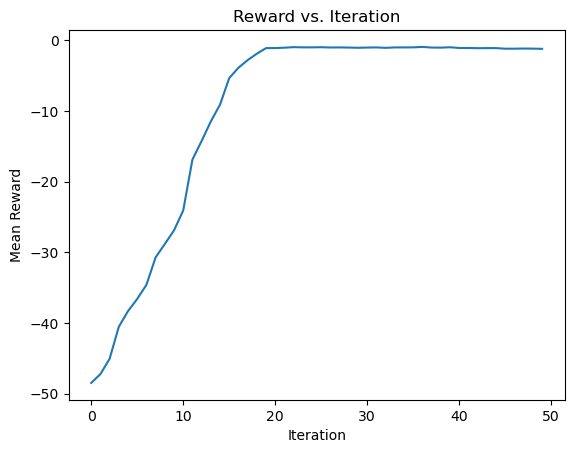

In [19]:
import matplotlib.pyplot as plt
rewards = [i["episode_reward_mean"] for i in callback.results]

plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Reward vs. Iteration")
plt.show()

In [6]:
best_result = results.get_best_result("episode_mean_reward","max")

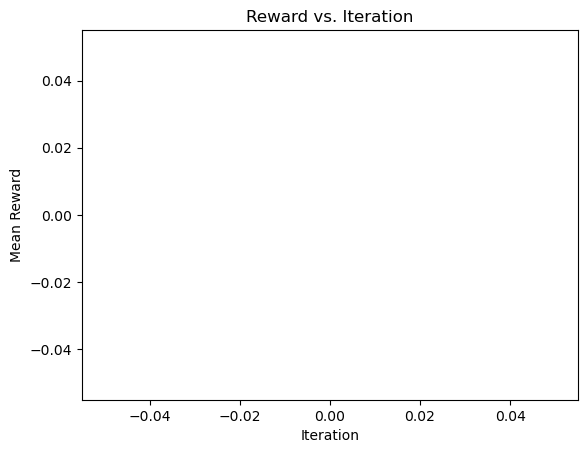

In [7]:
import matplotlib.pyplot as plt
rewards = [i["episode_reward_mean"] for i in callback.results]

plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Reward vs. Iteration")
plt.show()

In [8]:
# Get the best result
best_result = results.get_best_result()

# Get the best checkpoint
best_checkpoint = best_result.checkpoint

In [9]:
best_checkpoint

In [10]:
from ray.rllib.algorithms.algorithm import Algorithm
register_env("pb", pushButton)
algo = Algorithm.from_checkpoint(best_checkpoint)

NameError: name 'pushButton' is not defined

In [ ]:
from time import sleep
env = pushButton()
obs = env.reset()[0]
progression = []
done = False

In [ ]:
obs

In [ ]:
from IPython.display import clear_output
lastObs=obs
while not done:
    action = algo.compute_single_action(obs)
    obs, reward, done, info,ads = env.step(action)
    print(f"action: {action}")
    print(f"obs: {obs}")
    print(f"reward: {reward}")
    if lastObs==action:
        print("WIN")
    lastObs=obs
    sleep(1)
    clear_output(True)
    # progression.append(obs)